In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8397, -2.8199, -2.8828, -2.8164, -2.8835, -2.8756, -2.8411, -2.8890,
         -2.8919, -2.9383, -2.8595, -2.9733, -2.9760, -2.8356, -2.9059, -2.9528,
         -2.9626, -2.9056]], grad_fn=<LogSoftmaxBackward0>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 3)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Tokuoka
category = French / line = Charpentier
category = Spanish / line = Sepulveda
category = Arabic / line = Ganim
category = Spanish / line = Basurto
category = Portuguese / line = Pinho
category = Dutch / line = Schrijnemakers
category = Greek / line = Kouros
category = Russian / line = Holmogorov
category = English / line = Ludkin


In [9]:
criterion = nn.NLLLoss()

In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.6751 Rios / Greek ✗ (Portuguese)
10000 10% (0m 9s) 2.1281 Hirayama / Spanish ✗ (Japanese)
15000 15% (0m 14s) 2.1472 Rocca / Spanish ✗ (Italian)
20000 20% (0m 18s) 1.3167 Gou / Korean ✗ (Chinese)
25000 25% (0m 23s) 2.0857 Kruessel / German ✗ (Czech)
30000 30% (0m 28s) 0.9171 Reier / German ✓
35000 35% (0m 33s) 0.4932 Kasamatsu / Japanese ✓
40000 40% (0m 37s) 0.2813 Belluomi / Italian ✓
45000 45% (0m 41s) 2.7289 Ramos / Greek ✗ (Spanish)
50000 50% (0m 46s) 0.6848 Doyle / Irish ✓
55000 55% (0m 50s) 0.7778 Mikhail / Arabic ✓
60000 60% (0m 55s) 0.2906 Vinh / Vietnamese ✓
65000 65% (0m 59s) 3.3161 Gajos / Greek ✗ (Polish)
70000 70% (1m 4s) 0.0599 Divnov / Russian ✓
75000 75% (1m 8s) 1.3056 Albuquerque / French ✗ (Portuguese)
80000 80% (1m 13s) 2.1205 Lachance / English ✗ (French)
85000 85% (1m 17s) 1.9622 Nowak / Arabic ✗ (Czech)
90000 90% (1m 22s) 0.3910 Ku / Korean ✓
95000 95% (1m 26s) 0.5694 Anselmetti / Italian ✓
100000 100% (1m 30s) 0.6051 Mateus / Portuguese ✓


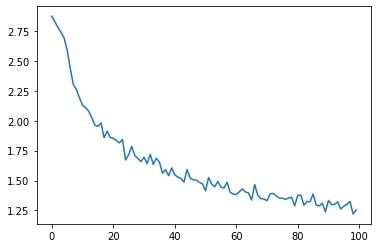

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_108533/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_108533/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


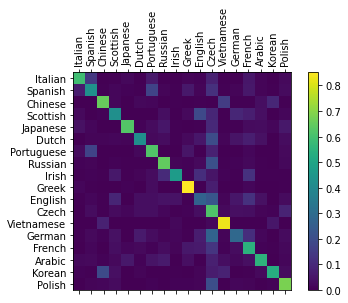

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.41) Russian
(-1.35) Czech
(-2.98) Polish

> Jackson
(-0.93) English
(-1.12) Czech
(-1.76) Russian

> Satoshi
(-0.69) Polish
(-1.76) Italian
(-2.20) Japanese


In [15]:
from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

# output, next_hidden = rnn(input[0], hidden)

mdf_model, params_dict = pytorch_to_mdf(
        model=rnn,
        args=(input[0], hidden),
        trace=True,
    )

In [16]:
mdf_graph = mdf_model.graphs[0]
params_dict["input1"] = input[0].detach().numpy()

eg = EvaluableGraph(graph=mdf_graph, verbose=False)

eg.evaluate(initializer=params_dict)

output_mdf = eg.output_enodes[0].get_output()


Init graph: RNNGraph
Evaluating graph: RNNGraph, root nodes: ['Concat_6'], with array format numpy


Fail: [ONNXRuntimeError] : 1 : FAIL : Type Error: Type parameter (T) of Optype (Concat) bound to different types (tensor(float) and tensor(int64) in node (Co_Concat).

In [17]:
mdf_model.to_graph_image(
    engine="dot",
    output_format="png",
    view_on_render=False,
    level=1,
    filename_root="example",
    only_warn_on_fail=True,
    is_horizontal = True
)

Converting MDF graph: RNNGraph to graphviz (level: 1, format: png)
    Node: Concat_6
    Node: Gemm_7
    Node: Gemm_8
    Node: LogSoftmax_9
    Edge: Concat_6_Gemm_7 connects Concat_6 to Gemm_7
    Edge: Concat_6_Gemm_8 connects Concat_6 to Gemm_8
    Edge: Gemm_8_LogSoftmax_9 connects Gemm_8 to LogSoftmax_9
Written graph image to: example.png
